In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
import gymnasium
from gymnasium import spaces


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecEnv

In [3]:
from stable_baselines3.common.vec_env.base_vec_env import VecEnv, VecEnvStepReturn, VecEnvWrapper

In [4]:
from stable_baselines3.common.vec_env import SubprocVecEnv

Aim of the moddeling:

- if you want to train multiple envs at once e.g. to do multiple abstraction levels design between: comprehensive levels as per Bathe, or scale (micro, macro), or different optimization objectives, or different action space, you can use SB3 Vectorized Environments in the below manner. For instance, for two or more Env you can combine the reward in any specific way thus ensuring communication between the abstraction levels.
- This notebook aims at imitating simultaneous micro and macro topology optimisation. The micro element is either stretched or compressed at its boundaries at random imitating what would elements experience at microstructure.

In [5]:
y0, x0 = 5, 5

In [6]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def mbb_beam_micro(width=y0, height=x0, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    
    normals[2, 1, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimensions!!!!!!!!!!!!!!!!!!
    normals[2, 1, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, x] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    normals[2, 3, y] = 1 #!!!!!!!!!!!!!!!!should be adjusted to account for any dimension!!!!!!!!!!!!!!!!!!!
    
    forces = np.zeros((width + 1, height + 1, 2))
    
    a=random.choice([1,-1])
    b=random.choice([1,-1])
    
    for j in range(0, width):
        forces[0, j, y] = a
        forces[height, j, y] = -a 
        
    for j in range(0, height):
        forces[j, 0, x] = b
        forces[j, width, x] = -b
    
    
    return normals, forces, density

In [7]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [8]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [9]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [10]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [11]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [12]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [13]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [14]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        a1=1/tmp
        a2=1-const
        self.reward =2*a1*a2/(a1+a2)
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

In [17]:
class CantileverEnvMicro(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args1 = get_args(*mbb_beam_micro(rd=self.rd)) 
        
        DIM=self.args1.nelx*self.args1.nely
        N_DISCRETE_ACTIONS=self.args1.nelx*self.args1.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args1 = get_args(*mbb_beam_micro(rd=self.rd)) 
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args1, self.x)
        
        self.step_+=1
        
        
        a1=1/tmp
        a2=1-const
        self.reward =2*a1*a2/(a1+a2)
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.7:
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1    
           
        self.x = anp.ones((self.args1.nely, self.args1.nelx))*self.args1.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

In [18]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [19]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env1 = CantileverEnv()
        self.env2 = CantileverEnvMicro()

        # Combine observation spaces (you could process these differently)
        self.observation_space = spaces.Dict({
            'macro': self.env1.observation_space,
            'micro': self.env2.observation_space
        })

        # Combine action spaces into a Dict space
        self.action_space = spaces.MultiDiscrete([25, 25])

    def reset(self,seed=0):
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        return {
            'macro': obs1,
            'micro': obs2
        }, {
            'macro': info1,
            'micro': info2
        }

    def step(self, action):
        a1 = action[0]
        a2 = action[1]

        obs1, r1, done1,_, info1 = self.env1.step(a1)
        obs2, r2, done2,_, info2 = self.env2.step(a2)

        cross_reward1 = 2*r1*r2/(r1+r2)
        cross_reward2 = r2 

        done = done1 or done2  # or you could choose more complex logic

        return {
            'macro': obs1,
            'micro': obs2
        }, (cross_reward1+cross_reward2), done, False, {
            'macro': info1,
            'micro': info2
        }

    def render(self, mode='human'):
        self.env1.render()
        self.env2.render()

    def close(self):
        self.env1.close()
        self.env2.close()




In [20]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X.reshape(y0, x0)) 
    plt.show() 

In [21]:
ts=1e6

In [22]:
# Create log dir
log_dir = "/tmp/gym6_2o1o1o/"
os.makedirs(log_dir, exist_ok=True)

In [23]:
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [24]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [25]:
start=time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()  

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 2000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 3000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 4000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 5000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 6000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 7000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 8000
Best mean reward: 0.05 - Last mean reward per episode: 0.05
Num timesteps: 9000
Best mean reward: 0.05 - Last mean reward per episode: 0.04
Num timesteps: 10000
Best mean reward: 0.05 - Last m

Num timesteps: 87000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 88000
Best mean reward: 0.08 - Last mean reward per episode: 0.08
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 89000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 90000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 91000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 92000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 93000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 94000
Best mean reward: 0.08 - Last mean reward per episode: 0.07
Num timesteps: 95000
Best mean reward: 0.08 - Last mean reward per episode: 0.08
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 96000
Best mean reward: 0.08 - Last mean reward per episode: 0.08
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 9700

Num timesteps: 179000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 180000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 181000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 182000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 183000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 184000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 185000
Best mean reward: 0.10 - Last mean reward per episode: 0.10
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 186000
Best mean reward: 0.10 - Last mean reward per episode: 0.10
Num timesteps: 187000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 188000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 189000
Best mean reward: 0.10 - Last mean reward per episode: 0.09
Num timesteps: 190000
Best mean reward: 0

Num timesteps: 275000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 276000
Best mean reward: 0.11 - Last mean reward per episode: 0.10
Num timesteps: 277000
Best mean reward: 0.11 - Last mean reward per episode: 0.10
Num timesteps: 278000
Best mean reward: 0.11 - Last mean reward per episode: 0.10
Num timesteps: 279000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 280000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 281000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 282000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 283000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 284000
Best mean reward: 0.11 - Last mean reward per episode: 0.10
Num timesteps: 285000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 286000
Best mean reward: 0.11 - Last mean reward per episode: 0.11
Num timesteps: 2

Num timesteps: 367000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 368000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 369000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 370000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 371000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 372000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Num timesteps: 373000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 374000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 375000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 376000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 377000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 378000
Best mean reward: 0

Num timesteps: 461000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 462000
Best mean reward: 0.14 - Last mean reward per episode: 0.13
Num timesteps: 463000
Best mean reward: 0.14 - Last mean reward per episode: 0.13
Num timesteps: 464000
Best mean reward: 0.14 - Last mean reward per episode: 0.13
Num timesteps: 465000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 466000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 467000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 468000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 469000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 470000
Best mean reward: 0.14 - Last mean reward per episode: 0.13
Num timesteps: 471000
Best mean reward: 0.14 - Last mean reward per episode: 0.14
Num timesteps: 472000
Best mean reward: 0

Num timesteps: 558000
Best mean reward: 0.15 - Last mean reward per episode: 0.14
Num timesteps: 559000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 560000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Saving new best model to /tmp/gym6_2o1o1o/best_model.zip
Num timesteps: 561000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 562000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 563000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 564000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 565000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 566000
Best mean reward: 0.15 - Last mean reward per episode: 0.14
Num timesteps: 567000
Best mean reward: 0.15 - Last mean reward per episode: 0.14
Num timesteps: 568000
Best mean reward: 0.15 - Last mean reward per episode: 0.15
Num timesteps: 569000
Best mean reward: 0

Num timesteps: 656000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 657000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 658000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 659000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 660000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 661000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 662000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 663000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 664000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 665000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 666000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 667000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 6

Num timesteps: 756000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 757000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 758000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 759000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 760000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 761000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 762000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 763000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 764000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 765000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 766000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 767000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 7

Num timesteps: 856000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 857000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 858000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 859000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 860000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 861000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 862000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 863000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 864000
Best mean reward: 0.16 - Last mean reward per episode: 0.15
Num timesteps: 865000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 866000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 867000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 8

Num timesteps: 955000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 956000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 957000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 958000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 959000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 960000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 961000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 962000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 963000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 964000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 965000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 966000
Best mean reward: 0.16 - Last mean reward per episode: 0.14
Num timesteps: 9

In [26]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 32.34684223333995 min


In [27]:
obs=env.reset()

In [28]:
obs=obs[0]

In [29]:
i=0
ans=[]
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones,_, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1


Final Cantilever beam design:


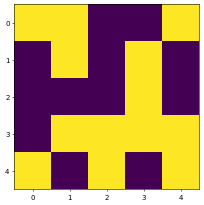

In [31]:
draw(ans[-1]['macro'])


Final Cantilever beam design:


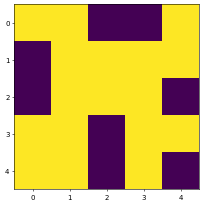

In [32]:
draw(ans[-1]['micro'])

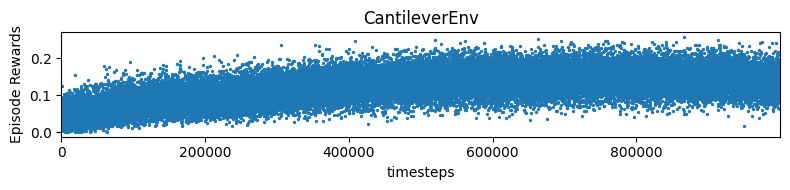

In [33]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [34]:
obs=env.reset()

In [35]:
obs=obs[0]

In [36]:
model_best = PPO.load(log_dir + "best_model.zip", env=env)

In [37]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones,_, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1


Final Cantilever beam design:


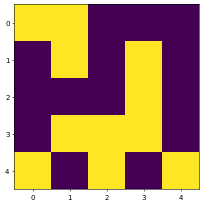

In [38]:
draw(ans[-1]['macro'])


Final Cantilever beam design:


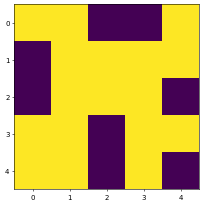

In [39]:
draw(ans[-1]['micro'])